In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

if torch.cuda.is_available():
    GPU_SCORE = torch.cuda.get_device_capability()
    if GPU_SCORE >= (8, 0):
        torch.backends.cuda.matmul.allow_tf32 = True

Classe: noturus nocturnus


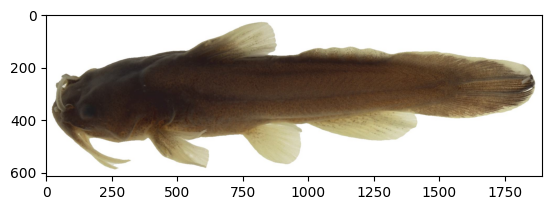

In [2]:
from PIL import Image
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the the fish_vista_repo_dir to the path of your cloned fish-vista HF repository
fish_vista_repo_dir = "dataset/fish-vista/"

# Read classification test and train csv files
train_path = os.path.join(fish_vista_repo_dir, "classification_train.csv")
train_df = pd.read_csv(train_path)

test_path = os.path.join(fish_vista_repo_dir, "classification_test.csv")
test_df = pd.read_csv(test_path)

# Get image at index 'idx'
idx = 0
classes = sorted(train_df.standardized_species.drop_duplicates())
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
img_class = train_df.iloc[idx].standardized_species
img_filename = train_df.iloc[idx].file_name

img_test = Image.open(os.path.join(fish_vista_repo_dir, img_filename))
plt.imshow(img_test)
print(f"Classe: {img_class}")

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms

class FishDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.img_labels = dataframe["standardized_species"].unique()
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe["filename"])

    def __getitem__(self, idx):
        label = class_to_idx[self.dataframe.iloc[idx].standardized_species]
        img_filename = self.dataframe.iloc[idx].file_name
        image = Image.open(self.root_dir + img_filename)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [5]:
BATCH_SIZE = 64
WORKERS = 0
train_dataset = FishDataset(train_df,fish_vista_repo_dir,data_transform)
test_dataset = FishDataset(test_df,fish_vista_repo_dir,data_transform)

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=WORKERS, 
                              shuffle=True,
                              generator=torch.Generator(device=device)) 

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=WORKERS, 
                             shuffle=False,
                             generator=torch.Generator(device=device))

In [6]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*32,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = TinyVGG(3,10,len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
      # 1. Forward pass
        y_pred = model(X)

      # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

      # 3. Optimizer zero grad
        optimizer.zero_grad()

      # 4. Loss backward
        loss.backward()

      # 5. Optimizer step
        optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

: 

In [ ]:
import torchinfo
EPOCHS = 1
train(model,train_dataloader,test_dataloader,optimizer,loss_fn,EPOCHS,device)

  0%|          | 0/1 [00:00<?, ?it/s]

27995
12826
14490
32135
16172
5622
13223
10666
20111
6320
442
23506
34572
27976
14306
13267
31640
7470
5665
3773
19265
151
31245
8549
9356
17412
26007
20542
19663
7692
19020
20035
975
24705
34233
31142
1676
32775
13585
16384
27804
6832
2780
30328
2968
30708
33450
30497
1493
30233
28683
22756
26929
7411
26220
26412
11977
23517
26000
23782
5177
20820
1552
25760
8664
18692
29412
5381
25684
8414
17722
5766
24383
12931
12959
20915
28111
8505
3503
17053
22671
21513
29709
8514
25254
6361
28608
12696
31021
23755
6470
31665
33579
32280
15060
28461
3086
22731
5695
10928
25748
298
34589
18262
22062
7077
8428
8051
23855
9628
25582
24595
10789
20322
22625
32461
3752
3737
18232
6468
4466
20947
22009
18678
8078
11652
4608
20301
34414
34155
27645
19730
24455
26285
12288
32788
7184
26739
14382
2621
22860
17484
8515
1331
2481
13293
28287
7126
23591
33189
29284
2021
4557
26605
19882
14199
15377
32652
15353
33126
5210
13354
31818
22965
33137
21019
6709
17481
4210
25767
4992
11832
13112
17697
10816
31394
1